# Numerical Panel Methods 🚢 

A panel method is a numerical approach to constructing potential flows around engineering shapes such as an offshore platform, sail or ship hull. Panel methods are typically fast enough for design iteration on 3D geometries, but they come with modelling and numerical errors that need to be quantified. 


## Potential of a source panel 🚰

The building block of the method is a surface panel; many of which are used to cover the boundaries of the flow domain. Each panel will have a different (constant) strength $q$, which are set such that flow moves around the engineering shape (not through it).  

The velocity potential of a panel is defined as

$$ \phi(\vec x) = q\int\int G(\vec x,\vec S(\xi,\zeta))\ d\xi d\zeta $$

where $S$ is the surface of the panel, described by two coordinates, $\xi,\zeta$ and $G$ is the Green Function, which needs to be a solution of the laplace equations $\nabla^2 G=0$. For every point $\vec x$ where you want the potential, you must evaluate this double integral over the surface coordinates.

The functions inside this integral are known: the geometry $S$ is _the_ input (a portion of a sphere, a bit of the hull defined by a spline, etc), and we will choose $G$ to be the source potential

$$ G(\vec x, \vec a) = \frac{-1}{|\vec x-\vec a|}$$

Despite this, the integral for $\phi$ is not analytically solvable, except for special-case $S$ shapes. This is in stark contrast to derivatives! If we had $\phi=\frac{\partial}{\partial \xi} G(x,S(\xi,\zeta))$ we would have no problem carrying out this derivative using the chain rule, even for complex shapes. Integrals don't have an equivalent rule that always works!

## Numerical integration quadratures

Numerical approximations to integrals are called _quadratures_. Consider the integral 

$$ F = \int_{-h/2}^{h/2} f(x) dx $$

You're already familiar with many example quadratures:
 - mid-point rule: $F \approx h f(0)$
 - trapezoid rule: $F \approx \frac h2 [f(-h/2)+f(h/2)]$
 - Simpson's rule: $F \approx \frac h6 [f(-h/2)+4f(0)+f(h/2)]$

These rules require 1,2 and 3 function evaluations, respectively. How much more accuracy are we getting for the increased amount of work? We can determine this by expressing $f$ in terms of it's Taylor series

$$ f(x) = f_0+\frac x2 f_0' + \frac{x^2}6 f_0'' + \frac{x^3}{12} f_0''' + \ldots $$

where subscript 0 denotes evaluation at $x=0$ and each tick $'$ indicates a derivative. Substitution into the integral and algebraic manipulation gives:
 - mid-point: $F = hf_0 + \frac 1{24} h^3 f_0'' + O(h^4)$
 - trapezoid: $F = \frac h2 [f(-h/2)+f(h/2)] -\frac 1{12}h^3 f_0''+O(h^4)$
 - Simpson's: $F = \frac h6 [f(-h/2)+4f(0)+f(h/2)] + O(h^4)$

where $O(h^4)$ means all the following terms are proportional to $h$ to the power of 4 or greater. Since our rules don't include these additional terms, our quadratures have a well-defined _numerical error_.

<div class="alert alert-success">
<b> 3: Numerical Truncation Error </b>

Errors due to truncating an infinite series at some power of the step length $h$
</div>

Unlike system description errors or modelling errors, numerical truncation errors can be well estimated and controlled without access to the "true" result. We can see that the simple midpoint rule is quite accurate: **as long as the function is smooth such that the derivatives don't blow up, a small value of $h$ will make $h^3 f''$ negligible**. The midpoint rule applied to our green's function integral gives:

$$ \phi(\vec x) \approx \frac{-Aq}{G(\vec x,\vec S_0)} $$

where $A$ and $\vec S_0$ are the area and centroid of the panel. Note that is just a point-source located at the panel centroid with $s=qA$!

_Q: In what cases will this approximation will be accurate, and when will it have large error?_



### 2D coding example

Let's look at an example using code: a 2D point source $G=\frac 12 \log(x^2)$ integrated on panels covering the x axis.

⚠️ WARNING ⚠️: This is Julia, not Python or MATLAB. The syntax is similar to Python and MATLAB and here is a list of [note-worthy differences between Julia and other languages](https://web.mit.edu/julia_v0.6.2/julia/share/doc/julia/html/en/manual/noteworthy-differences.html) to help you make the switch.
![Julia benchmarks](https://julialang.org/assets/images/benchmarks.svg)
Julia has a bunch of advantages that we need in this class - primarily [speed](https://julialang.org/benchmarks/)!

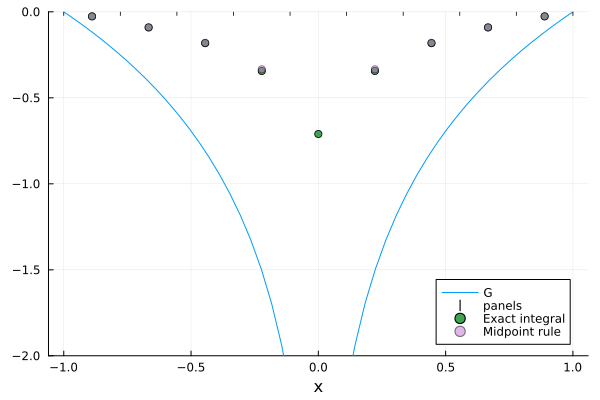

In [25]:
# First define the functions we need
### Look how easy this is in Julia! No more `def G(x): return stuff`
G(x) = 0.5log(x^2)                 # 2D source at x₀=0
G_int(x) = 0.5x*log(x^2)-x         # indefinite integral
midpoint(f,a,b) = (b-a)*f((a+b)/2) # Midpoint rule for any function `f`

# Next let's plot the Green's function 
### Plots is the basic plotting package for Julia
using Plots 
plot(range(-1,1,50),G,label="G",ylims=(-2,0),xlabel="x")

# Split up the x-axis into panels
### The range function and slicing is like Python
### but adding vectors works automatically 
x = range(-1,1,10) # "panels" running along x-axis
scatter!(x,zero,shape=:vline,c=:black,label="panels")
a = x[1:end-1]     # lower limits of each panel
b = x[2:end]       # upper limits
m = (a+b)/2        # panel midpoint

# Finally, we can compare the exact and numeric panel integrals
### The `.` syntax "broadcasts" the function over the arguments
### like an automatic list comprehension or do loop.
exact = G_int.(b) - G_int.(a) # same as [G_int(aᵢ)-G_int(bᵢ) for (aᵢ,bᵢ) in zip(a,b)]
numeric = midpoint.(G,a,b)    # same as [midpoint(G,aᵢ,bᵢ) for (aᵢ,bᵢ) in zip(a,b)]
scatter!(m,exact,label="Exact integral")
scatter!(m,numeric,alpha=0.5,label="Midpoint rule")

The exact integral and the midpoint rule results are directly on top of each other at the edges of the range. However, as $|x|\leftarrow 0$, the value of $|G''|\leftarrow \infty$ and the error becomes noticable. Because $G_0=-\infty$ the midpoint rule is singular despite the fact that the true integral is well defined.